In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt': ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan', '?'], index_col='dt')

In [3]:
print(df.isnull().sum())

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [4]:
# Handling Missing Values
df.interpolate(method='linear', inplace=True)
df.fillna(method='ffill', inplace=True)

In [5]:
print(df.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [6]:
# Compute Total Consumption (TM)
df['Total_consumption'] = (df['Global_active_power'] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

In [7]:
# Selecting Features and Targets
X = df[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].values
y = df[['Total_consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].values

In [19]:
print(df.head())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [8]:
# Splitting dataset into 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

In [9]:
# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Save the scalers
joblib.dump(scaler_X, 'models/scaler_X.pkl')
joblib.dump(scaler_y, 'models/scaler_y.pkl')

['models/scaler_y.pkl']

In [10]:
# Reshape for sequence models
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
# Define the updated model
def cnn_bigru_attention_model():
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_layer)
    cnn = tf.keras.layers.LeakyReLU()(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.4)(cnn)

    cnn = Conv1D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(cnn)
    cnn = tf.keras.layers.LeakyReLU()(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.4)(cnn)
    cnn = Flatten()(cnn)

    # BiGRU Branch
    bigru = Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2))(input_layer)
    bigru = LayerNormalization()(bigru)
    bigru = Dropout(0.4)(bigru)

    bigru = Bidirectional(GRU(128, return_sequences=True, recurrent_dropout=0.2))(bigru)
    bigru = LayerNormalization()(bigru)
    bigru = Dropout(0.4)(bigru)

    # Attention Mechanism
    attention = tf.keras.layers.Attention()([bigru, bigru])
    attention = Flatten()(attention)

    # Merge both branches
    merged = Concatenate()([cnn, attention])

    # Fully connected layers
    dense = Dense(128, activation='relu')(merged)
    out = Dense(4, activation='linear')(dense)  # 4 outputs (TM, SM1, SM2, SM3)

    # Define and compile the model
    model = Model(inputs=input_layer, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

In [15]:
model = cnn_bigru_attention_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6, 64)        256         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 6, 64)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 6, 128)       25728       input_1[0][0]                    
______________________________________________________________________________________________

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Create and train the model

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=256,
                    callbacks=[early_stopping, reduce_lr])

# Save the model
model.save('models/consumption_model.h5')


Epoch 1/50
6486/6486 [==============================] - 986s 150ms/step - loss: 0.0256 - val_loss: 0.0050
Epoch 2/50
6486/6486 [==============================] - 576s 89ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 3/50
6486/6486 [==============================] - 562s 87ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 4/50
6486/6486 [==============================] - 564s 87ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 5/50
6486/6486 [==============================] - 565s 87ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 6/50
6486/6486 [==============================] - 590s 91ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 7/50
6486/6486 [==============================] - 589s 91ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 8/50
6486/6486 [==============================] - 590s 91ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 9/50
6486/6486 [==============================] - 589s 91ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 10/50
6486/6486 [==============================]

In [17]:
# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Reverse scaling
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)
y_train_pred = scaler_y.inverse_transform(y_train_pred)
y_val_pred = scaler_y.inverse_transform(y_val_pred)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

# Evaluation Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'{dataset_name} - R^2: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_val, y_val_pred, "Validation")
evaluate_model(y_test, y_test_pred, "Test")


Training - R^2: 0.9991, MSE: 0.0843, RMSE: 0.2904
Validation - R^2: 0.9981, MSE: 0.0775, RMSE: 0.2783
Test - R^2: 0.9983, MSE: 0.0845, RMSE: 0.2907


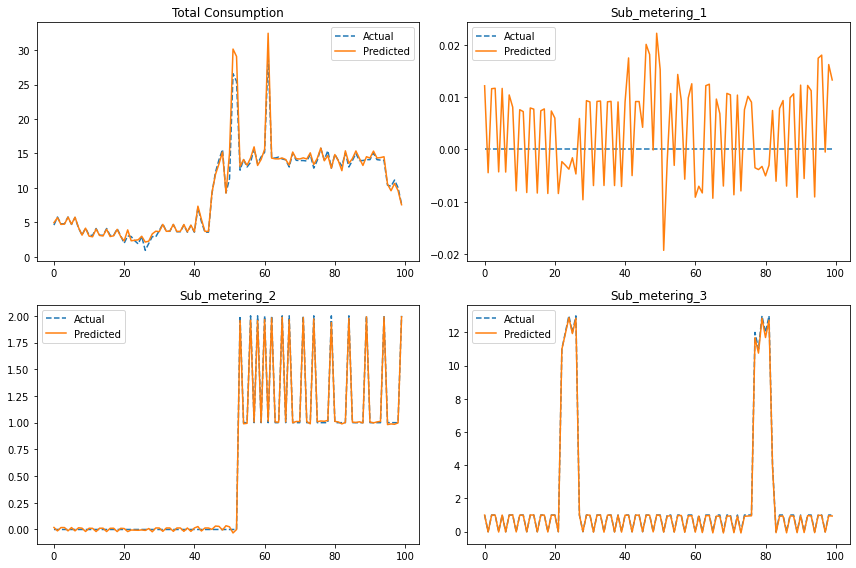

In [18]:

# Plot actual vs predicted values
labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(4):
    axes[i].plot(y_test[:100, i], label='Actual', linestyle='dashed')
    axes[i].plot(y_test_pred[:100, i], label='Predicted')
    axes[i].set_title(labels[i])
    axes[i].legend()

plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import joblib
import tensorflow as tf

# Load trained model and scalers
model = tf.keras.models.load_model('models/consumption_model.h5')
scaler_X = joblib.load('models/scaler_X.pkl')
scaler_y = joblib.load('models/scaler_y.pkl')

# Function to get user input
def get_user_input():
    print("\nEnter future electricity consumption input values:")
    global_reactive_power = float(input("Global Reactive Power (kW): "))
    voltage = float(input("Voltage (V): "))
    global_intensity = float(input("Global Intensity (A): "))
    sub_metering_1 = float(input("Sub Metering 1: "))
    sub_metering_2 = float(input("Sub Metering 2: "))
    sub_metering_3 = float(input("Sub Metering 3: "))
    
    return np.array([[global_reactive_power, voltage, global_intensity, sub_metering_1, sub_metering_2, sub_metering_3]])

# Get input from the user
future_data = get_user_input()

# Scale the input using the trained scaler
future_data_scaled = scaler_X.transform(future_data)

# Reshape to match model input shape (samples, features, 1)
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], future_data_scaled.shape[1], 1))

# Predict future consumption values
future_pred_scaled = model.predict(future_data_scaled)

# Inverse transform to get actual values
future_pred = scaler_y.inverse_transform(future_pred_scaled)

# Display the prediction
labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
predicted_values = dict(zip(labels, future_pred[0]))

print("\n🔮 Future Electricity Consumption Predictions:")
for key, value in predicted_values.items():
    print(f"{key}: {value:.2f}")



Enter future electricity consumption input values:

🔮 Future Electricity Consumption Predictions:
Total Consumption: 70.06
Sub_metering_1: 0.01
Sub_metering_2: 1.74
Sub_metering_3: 16.80


In [24]:
import numpy as np
import joblib
import tensorflow as tf

# Load trained model and scalers
model = tf.keras.models.load_model('models/consumption_model.h5')
scaler_X = joblib.load('models/scaler_X.pkl')
scaler_y = joblib.load('models/scaler_y.pkl')

# Function to get user input
def get_user_input():
    print("\nEnter future electricity consumption input values:")
    user_inputs = {
        "Global Reactive Power (kW)": float(input("Global Reactive Power (kW): ")),
        "Voltage (V)": float(input("Voltage (V): ")),
        "Global Intensity (A)": float(input("Global Intensity (A): ")),
        "Sub Metering 1": float(input("Sub Metering 1: ")),
        "Sub Metering 2": float(input("Sub Metering 2: ")),
        "Sub Metering 3": float(input("Sub Metering 3: ")),
    }
    
    return np.array([list(user_inputs.values())]), user_inputs

# Get input from the user
future_data, user_inputs = get_user_input()

# Display the entered values
print("\n📝 Entered Values:")
for key, value in user_inputs.items():
    print(f"{key}: {value}")

# Scale the input using the trained scaler
future_data_scaled = scaler_X.transform(future_data)

# Reshape to match model input shape (samples, features, 1)
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], future_data_scaled.shape[1], 1))

# Predict future consumption values
future_pred_scaled = model.predict(future_data_scaled)

# Inverse transform to get actual values
future_pred = scaler_y.inverse_transform(future_pred_scaled)

# Display the prediction
labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
predicted_values = dict(zip(labels, future_pred[0]))

print("\n🔮 Future Electricity Consumption Predictions:")
for key, value in predicted_values.items():
    print(f"{key}: {value:.2f}")



Enter future electricity consumption input values:

📝 Entered Values:
Global Reactive Power (kW): 0.498
Voltage (V): 233.29
Global Intensity (A): 23.0
Sub Metering 1: 0.0
Sub Metering 2: 2.0
Sub Metering 3: 17.0

🔮 Future Electricity Consumption Predictions:
Total Consumption: 70.04
Sub_metering_1: 0.01
Sub_metering_2: 1.74
Sub_metering_3: 16.80


In [25]:
import numpy as np
import joblib
import tensorflow as tf

# Load trained model and scalers
model = tf.keras.models.load_model('models/consumption_model.h5')
scaler_X = joblib.load('models/scaler_X.pkl')
scaler_y = joblib.load('models/scaler_y.pkl')

# Function to get user input
def get_user_input():
    print("\nEnter future electricity consumption input values:")
    user_inputs = {
        "Global Reactive Power (kW)": float(input("Global Reactive Power (kW): ")),
        "Voltage (V)": float(input("Voltage (V): ")),
        "Global Intensity (A)": float(input("Global Intensity (A): ")),
        "Sub Metering 1": float(input("Sub Metering 1: ")),
        "Sub Metering 2": float(input("Sub Metering 2: ")),
        "Sub Metering 3": float(input("Sub Metering 3: ")),
    }
    
    return np.array([list(user_inputs.values())]), user_inputs

# Get input from the user
future_data, user_inputs = get_user_input()

# Display the entered values
print("\n📝 Entered Values:")
for key, value in user_inputs.items():
    print(f"{key}: {value}")

# Scale the input using the trained scaler
future_data_scaled = scaler_X.transform(future_data)

# Reshape to match model input shape (samples, features, 1)
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], future_data_scaled.shape[1], 1))

# Predict future consumption values
future_pred_scaled = model.predict(future_data_scaled)

# Inverse transform to get actual values
future_pred = scaler_y.inverse_transform(future_pred_scaled)

# Extract predicted values
labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
predicted_values = dict(zip(labels, future_pred[0]))

# Calculate Global Active Power (GAP)
TM = predicted_values["Total Consumption"]
SM1 = predicted_values["Sub_metering_1"]
SM2 = predicted_values["Sub_metering_2"]
SM3 = predicted_values["Sub_metering_3"]

predicted_GAP = (TM + SM1 + SM2 + SM3) * 60 / 1000  # Derived from the formula

# Display predictions
print("\n🔮 Future Electricity Consumption Predictions:")
for key, value in predicted_values.items():
    print(f"{key}: {value:.2f}")

print(f"\n⚡ Predicted Global Active Power (GAP): {predicted_GAP:.4f} kW")



Enter future electricity consumption input values:

📝 Entered Values:
Global Reactive Power (kW): 0.498
Voltage (V): 233.29
Global Intensity (A): 23.0
Sub Metering 1: 0.0
Sub Metering 2: 2.0
Sub Metering 3: 17.0

🔮 Future Electricity Consumption Predictions:
Total Consumption: 70.04
Sub_metering_1: 0.01
Sub_metering_2: 1.74
Sub_metering_3: 16.80

⚡ Predicted Global Active Power (GAP): 5.3156 kW


In [26]:
import numpy as np
import joblib
import tensorflow as tf

# Load trained model and scalers
model = tf.keras.models.load_model('models/consumption_model.h5')
scaler_X = joblib.load('models/scaler_X.pkl')
scaler_y = joblib.load('models/scaler_y.pkl')

# Function to get user input
def get_user_input():
    print("\nEnter future electricity consumption input values:")
    user_inputs = {
        "Global Reactive Power (kW)": float(input("Global Reactive Power (kW): ")),
        "Voltage (V)": float(input("Voltage (V): ")),
        "Global Intensity (A)": float(input("Global Intensity (A): ")),
        "Sub Metering 1": float(input("Sub Metering 1: ")),
        "Sub Metering 2": float(input("Sub Metering 2: ")),
        "Sub Metering 3": float(input("Sub Metering 3: ")),
    }
    
    return np.array([list(user_inputs.values())]), user_inputs

# Get input from the user
future_data, user_inputs = get_user_input()

# Display the entered values
print("\n📝 Entered Values:")
for key, value in user_inputs.items():
    print(f"{key}: {value}")

# Scale the input using the trained scaler
future_data_scaled = scaler_X.transform(future_data)

# Reshape to match model input shape (samples, features, 1)
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], future_data_scaled.shape[1], 1))

# Predict future consumption values
future_pred_scaled = model.predict(future_data_scaled)

# Inverse transform to get actual values
future_pred = scaler_y.inverse_transform(future_pred_scaled)

# Extract predicted values
labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
predicted_values = dict(zip(labels, future_pred[0]))

# Calculate Global Active Power (GAP)
TM = predicted_values["Total Consumption"]
SM1 = predicted_values["Sub_metering_1"]
SM2 = predicted_values["Sub_metering_2"]
SM3 = predicted_values["Sub_metering_3"]

predicted_GAP = (TM + SM1 + SM2 + SM3) * 60 / 1000  # Derived from the formula

# Display predictions
print("\n🔮 Future Electricity Consumption Predictions:")
for key, value in predicted_values.items():
    print(f"{key}: {value:.2f}")

print(f"\n⚡ Predicted Global Active Power (GAP): {predicted_GAP:.4f} kW")



Enter future electricity consumption input values:

📝 Entered Values:
Global Reactive Power (kW): 0.522
Voltage (V): 235.02
Global Intensity (A): 15.0
Sub Metering 1: 0.0
Sub Metering 2: 2.0
Sub Metering 3: 17.0

🔮 Future Electricity Consumption Predictions:
Total Consumption: 39.61
Sub_metering_1: -0.02
Sub_metering_2: 1.94
Sub_metering_3: 16.97

⚡ Predicted Global Active Power (GAP): 3.5097 kW


In [27]:
import numpy as np
import joblib
import tensorflow as tf

# Load trained model and scalers
model = tf.keras.models.load_model('models/consumption_model.h5')
scaler_X = joblib.load('models/scaler_X.pkl')
scaler_y = joblib.load('models/scaler_y.pkl')

# Function to get user input
def get_user_input():
    print("\nEnter future electricity consumption input values:")
    user_inputs = {
        "Global Reactive Power (kW)": float(input("Global Reactive Power (kW): ")),
        "Voltage (V)": float(input("Voltage (V): ")),
        "Global Intensity (A)": float(input("Global Intensity (A): ")),
        "Sub Metering 1": float(input("Sub Metering 1: ")),
        "Sub Metering 2": float(input("Sub Metering 2: ")),
        "Sub Metering 3": float(input("Sub Metering 3: ")),
    }
    
    return np.array([list(user_inputs.values())]), user_inputs

# Get input from the user
future_data, user_inputs = get_user_input()

# Display the entered values
print("\n📝 Entered Values:")
for key, value in user_inputs.items():
    print(f"{key}: {value}")

# Scale the input using the trained scaler
future_data_scaled = scaler_X.transform(future_data)

# Reshape to match model input shape (samples, features, 1)
future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], future_data_scaled.shape[1], 1))

# Predict future consumption values
future_pred_scaled = model.predict(future_data_scaled)

# Inverse transform to get actual values
future_pred = scaler_y.inverse_transform(future_pred_scaled)

# Extract predicted values
labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
predicted_values = dict(zip(labels, future_pred[0]))

# Calculate Global Active Power (GAP)
TM = predicted_values["Total Consumption"]
SM1 = predicted_values["Sub_metering_1"]
SM2 = predicted_values["Sub_metering_2"]
SM3 = predicted_values["Sub_metering_3"]

predicted_GAP = (TM + SM1 + SM2 + SM3) * 60 / 1000  # Derived from the formula

# Display predictions
print("\n🔮 Future Electricity Consumption Predictions:")
for key, value in predicted_values.items():
    print(f"{key}: {value:.2f}")

print(f"\n⚡ Predicted Global Active Power (GAP): {predicted_GAP:.4f} kW")



Enter future electricity consumption input values:

📝 Entered Values:
Global Reactive Power (kW): 0.076
Voltage (V): 234.17
Global Intensity (A): 16.4
Sub Metering 1: 0.0
Sub Metering 2: 0.0
Sub Metering 3: 17.0

🔮 Future Electricity Consumption Predictions:
Total Consumption: 47.39
Sub_metering_1: -0.01
Sub_metering_2: 0.01
Sub_metering_3: 16.97

⚡ Predicted Global Active Power (GAP): 3.8612 kW


In [6]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf

# Load trained model and scalers
model = tf.keras.models.load_model('models/consumption_model.h5')
scaler_X = joblib.load('models/scaler_X.pkl')
scaler_y = joblib.load('models/scaler_y.pkl')

# Function to get user input (CSV file)
def get_csv_input():
    file_path = input("\n📂 Enter the path of the CSV file: ")
    
    # Load CSV file
    try:
        df = pd.read_csv(file_path)
        required_features = ["Global Reactive Power (kW)", "Voltage (V)", "Global Intensity (A)", 
                             "Sub Metering 1", "Sub Metering 2", "Sub Metering 3"]
        
        # Check if all required features exist in the CSV
        missing_features = [f for f in required_features if f not in df.columns]
        if missing_features:
            raise ValueError(f"Missing required features in CSV: {missing_features}")
        
        return df[required_features]
    
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Get input from CSV
csv_data = get_csv_input()
if csv_data is not None:
    # Scale the input using the trained scaler
    future_data_scaled = scaler_X.transform(csv_data)
    
    # Reshape to match model input shape (samples, features, 1)
    future_data_scaled = future_data_scaled.reshape((future_data_scaled.shape[0], future_data_scaled.shape[1], 1))

    # Predict future consumption values
    future_pred_scaled = model.predict(future_data_scaled)

    # Inverse transform to get actual values
    future_pred = scaler_y.inverse_transform(future_pred_scaled)

    # Extract predictions into a DataFrame
    labels = ['Total Consumption', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    predictions_df = pd.DataFrame(future_pred, columns=labels)

    # Ensure sub-metering values are positive when displayed
    for col in ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
        predictions_df[col] = predictions_df[col].abs()

    # Calculate Global Active Power (GAP) for each row
    predictions_df["Predicted GAP (kW)"] = (predictions_df["Total Consumption"] + 
                                            predictions_df["Sub_metering_1"] + 
                                            predictions_df["Sub_metering_2"] + 
                                            predictions_df["Sub_metering_3"]) * 60 / 1000

    # Display predictions row-wise
    print("\n🔮 Future Electricity Consumption Predictions:")
    for index, row in predictions_df.iterrows():
        print(f"\n📊 Prediction for Row {index + 1}:")
        print(f"Total Consumption: {row['Total Consumption']:.2f}")
        print(f"Sub_metering_1: {row['Sub_metering_1']:.2f}")
        print(f"Sub_metering_2: {row['Sub_metering_2']:.2f}")
        print(f"Sub_metering_3: {row['Sub_metering_3']:.2f}")
        print(f"⚡ Predicted GAP: {row['Predicted GAP (kW)']:.4f} kW")

    # Save results to CSV
    predictions_df.to_csv("predicted_results.csv", index=False)
    print("\n✅ Predictions saved to 'predicted_results.csv'.")



🔮 Future Electricity Consumption Predictions:

📊 Prediction for Row 1:
Total Consumption: 70.04
Sub_metering_1: 0.01
Sub_metering_2: 1.74
Sub_metering_3: 16.80
⚡ Predicted GAP: 5.3156 kW

📊 Prediction for Row 2:
Total Consumption: 39.61
Sub_metering_1: 0.02
Sub_metering_2: 1.94
Sub_metering_3: 16.97
⚡ Predicted GAP: 3.5123 kW

📊 Prediction for Row 3:
Total Consumption: 47.39
Sub_metering_1: 0.01
Sub_metering_2: 0.01
Sub_metering_3: 16.97
⚡ Predicted GAP: 3.8629 kW

📊 Prediction for Row 4:
Total Consumption: 30.21
Sub_metering_1: 0.12
Sub_metering_2: 37.18
Sub_metering_3: 15.97
⚡ Predicted GAP: 5.0085 kW

📊 Prediction for Row 5:
Total Consumption: 55.44
Sub_metering_1: 0.18
Sub_metering_2: 36.96
Sub_metering_3: 15.90
⚡ Predicted GAP: 6.5085 kW

📊 Prediction for Row 6:
Total Consumption: 18.95
Sub_metering_1: 0.06
Sub_metering_2: 21.98
Sub_metering_3: 17.96
⚡ Predicted GAP: 3.5365 kW

✅ Predictions saved to 'predicted_results.csv'.


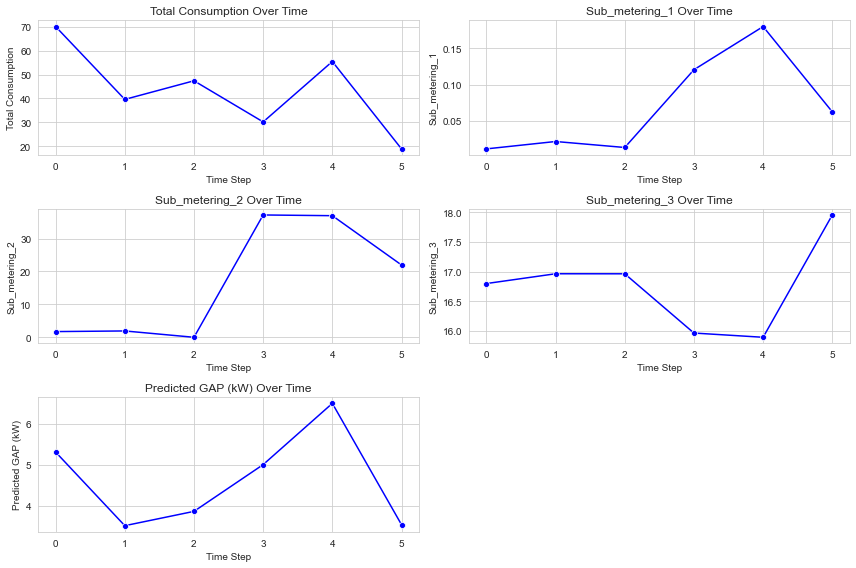

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load predicted results
predictions_df = pd.read_csv("predicted_results.csv")

# Set Seaborn style
sns.set_style("whitegrid")

# Plot each feature
plt.figure(figsize=(12, 8))

for i, column in enumerate(predictions_df.columns, 1):
    plt.subplot(3, 2, i)  # Adjust subplot grid (3 rows, 2 columns)
    sns.lineplot(data=predictions_df[column], marker='o', linestyle='-', color='b')
    plt.title(f"{column} Over Time")
    plt.xlabel("Time Step")
    plt.ylabel(column)

plt.tight_layout()
plt.show()
